# Covid-19 Vaccination Campaign in Germany

The data used here were provided by 
[Robert Koch Institute](https://www.rki.de) and the [German federal ministry of Health](https://www.bundesgesundheitsministerium.de/).

These institutions publish the datasets and some analysis on the page [impfdashboard.de](https://impfdashboard.de/).

## Get and Transform Data

In [1]:
# standard library
import datetime
import math

In [2]:
# third party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

In [3]:
today = datetime.datetime.today().strftime('%Y-%m-%d')
today

'2021-04-13'

In [4]:
yesterday = (datetime.datetime.today() + datetime.timedelta(days=-1)).strftime('%Y-%m-%d')
yesterday

'2021-04-12'

In [5]:
vaccination_data_permalink = 'https://impfdashboard.de/static/data/germany_vaccinations_timeseries_v2.tsv'
vaccinations = pd.read_csv(
    vaccination_data_permalink,
    sep="\t")

In [6]:
vaccinations.head(3)

,date,dosen_kumulativ,dosen_differenz_zum_vortag,dosen_erst_differenz_zum_vortag,dosen_zweit_differenz_zum_vortag,dosen_biontech_kumulativ,dosen_moderna_kumulativ,dosen_astrazeneca_kumulativ,personen_erst_kumulativ,personen_voll_kumulativ,...,indikation_medizinisch_dosen,indikation_pflegeheim_dosen,indikation_alter_erst,indikation_beruf_erst,indikation_medizinisch_erst,indikation_pflegeheim_erst,indikation_alter_voll,indikation_beruf_voll,indikation_medizinisch_voll,indikation_pflegeheim_voll
0,2020-12-27,24296,24296,24159,137,24296,0,0,24159,137,...,1305,12604,10664,8590,1305,12536,41,67,0,68
1,2020-12-28,42679,18383,18383,0,42679,0,0,42542,137,...,1991,21344,18580,15721,1991,21276,41,67,0,68
2,2020-12-29,91574,48895,48306,589,91574,0,0,90848,726,...,3107,40508,34724,40420,3107,40099,265,314,0,409


In [7]:
# Drop unnecessary columns
# No analysis of indication planned:
cols_to_drop = vaccinations.columns[vaccinations.columns.str.contains('indikation_')]
vaccinations.drop(columns=cols_to_drop, inplace=True)

In [8]:
# Convert datatype of date column
vaccinations.iloc[ : , [0]] = vaccinations.iloc[ : , [0]].apply(pd.to_datetime)

In [9]:
vaccinations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   date                              107 non-null    datetime64[ns]
 1   dosen_kumulativ                   107 non-null    int64         
 2   dosen_differenz_zum_vortag        107 non-null    int64         
 3   dosen_erst_differenz_zum_vortag   107 non-null    int64         
 4   dosen_zweit_differenz_zum_vortag  107 non-null    int64         
 5   dosen_biontech_kumulativ          107 non-null    int64         
 6   dosen_moderna_kumulativ           107 non-null    int64         
 7   dosen_astrazeneca_kumulativ       107 non-null    int64         
 8   personen_erst_kumulativ           107 non-null    int64         
 9   personen_voll_kumulativ           107 non-null    int64         
 10  impf_quote_erst                   107 non-null    

## Doses Used

In [10]:
doses = vaccinations.loc[ : , ['date', 'dosen_differenz_zum_vortag']]
doses.columns = ['date', 'doses used']

### Doses Daily

In [11]:
doses_daily = doses.set_index('date', inplace=False)
doses_daily.tail(1)

,doses used
date,
2021-04-12,399891


In [12]:
# What is the highest number of doses used in a day?
max_doses_daily = max(doses_daily['doses used'])
max_doses_daily

723916

<AxesSubplot:title={'center':'VACCINATION DOSES PER DAY IN GERMANY'}, xlabel='Date', ylabel='Million Doses'>

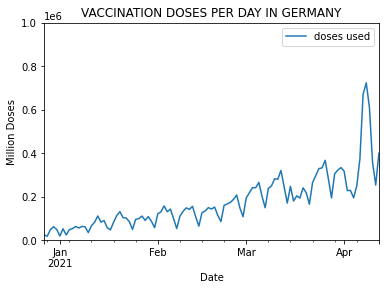

In [13]:
doses_daily.plot(
    ylim=(0,math.ceil(max_doses_daily / 10**6) * 10**6),
    xlabel='Date',
    ylabel='Million Doses',
    title='VACCINATION DOSES PER DAY IN GERMANY')

### Doses per Week

In [14]:
# W-Mon in order to start the week on a Monday, see:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#anchored-offsets
doses_weekly = doses.groupby(pd.Grouper(key='date',freq='W-Mon')).sum()
doses_weekly.tail()

,doses used
date,
2021-03-15,1797487
2021-03-22,1467147
2021-03-29,2108962
2021-04-05,1875013
2021-04-12,3393485


In [15]:
# What is the highest number of doses used in a week?
max_doses_weekly = max(doses_weekly['doses used'])
max_doses_weekly

3393485

<AxesSubplot:title={'center':'VACCINATION DOSES PER WEEK IN GERMANY'}, xlabel='Date', ylabel='Million Doses'>

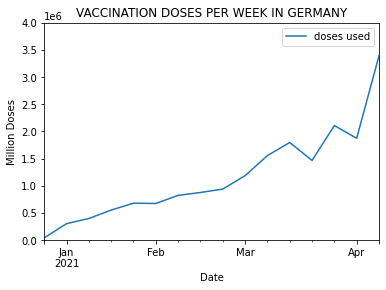

In [16]:
doses_weekly.plot(
    ylim=(0,math.ceil(max_doses_weekly / 10**6) * 10**6),
    xlabel='Date',
    ylabel='Million Doses',
    title='VACCINATION DOSES PER WEEK IN GERMANY')

### Doses per Month

In [17]:
# M = month end frequency
doses_monthly = doses.groupby(pd.Grouper(key='date',freq='M')).sum()
doses_monthly.tail()

,doses used
date,
2020-12-31,202796
2021-01-31,2332630
2021-02-28,3756932
2021-03-31,7780390
2021-04-30,4612125


In [18]:
max_doses_monthly = max(doses_monthly['doses used'])
max_doses_monthly
doses_monthly['month'] = doses_monthly.index.strftime('%B')
doses_monthly['year'] =  doses_monthly.index.strftime('%Y')
doses_monthly['label'] = doses_monthly['month'] + ' ' + doses_monthly['year']
doses_monthly.drop(columns=['month', 'year'], inplace=True)
doses_monthly.set_index('label', inplace=True)
doses_monthly.tail(6)

,doses used
label,
December 2020,202796
January 2021,2332630
February 2021,3756932
March 2021,7780390
April 2021,4612125


<AxesSubplot:title={'center':'VACCINATION DOSES PER MONTH IN GERMANY\n(as of 2021-04-13)'}, xlabel='Date', ylabel='Million Doses'>

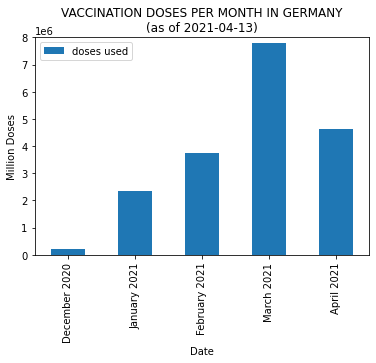

In [19]:
doses_monthly.plot.bar(
    ylim=(0,math.ceil(max_doses_monthly / 10**6) * 10**6),
    xlabel='Date',
    ylabel='Million Doses',
    title=f"VACCINATION DOSES PER MONTH IN GERMANY\n(as of {today})")

## Vaccination Campaign Progress

In [20]:
doses_cumulative = vaccinations.loc[ : , ['date', 'personen_erst_kumulativ', 'personen_voll_kumulativ']]
doses_cumulative.set_index('date', inplace=True)
doses_cumulative.head(3)

,personen_erst_kumulativ,personen_voll_kumulativ
date,,
2020-12-27,24159,137
2020-12-28,42542,137
2020-12-29,90848,726


In [21]:
population_germany = 83_200_000
# Calculate new fields
doses_cumulative['first vaccination'] = round(
    doses_cumulative['personen_erst_kumulativ'] * 100 / population_germany,
    2)
doses_cumulative['fully vaccinated'] = round(
    doses_cumulative['personen_voll_kumulativ'] * 100 / population_germany,
    2)
doses_cumulative.drop(columns=['personen_erst_kumulativ','personen_voll_kumulativ'], inplace=True)
doses_cumulative.tail(3)

,first vaccination,fully vaccinated
date,,
2021-04-10,15.67,6.00
2021-04-11,15.92,6.06
2021-04-12,16.31,6.15


<AxesSubplot:title={'center':'Vaccination Progress Germany\n(as of 2021-04-13)'}, xlabel='Date', ylabel='Percentage of Population in Germany'>

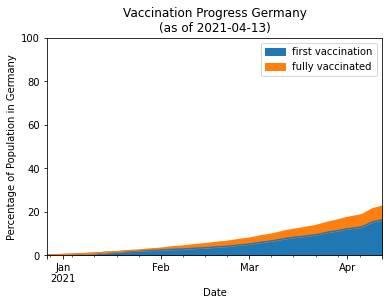

In [22]:
doses_cumulative.plot.area(
    ylim=(0,100),
    xlabel='Date',
    ylabel='Percentage of Population in Germany',
    title=f"Vaccination Progress Germany\n(as of {today})")

### As of Today

In [23]:
# get the last line of the data
current_state = doses_cumulative.iloc[-1]
current_state


first vaccination    16.31
fully vaccinated      6.15
Name: 2021-04-12 00:00:00, dtype: float64

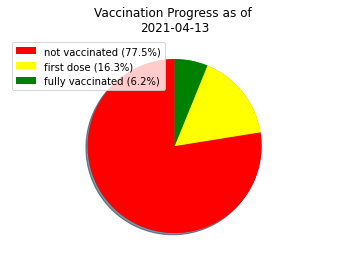

In [24]:
percentage_not_vacc = 100 - current_state['first vaccination'] - current_state['fully vaccinated']
labels = [f"not vaccinated ({round(percentage_not_vacc, 1)}%)",
          f"first dose ({round(current_state['first vaccination'],1)}%)",
          f"fully vaccinated ({round(current_state['fully vaccinated'],1)}%)"]
colors = ['red', 'yellow', 'green']
sizes = [percentage_not_vacc,
         current_state['first vaccination'],
         current_state['fully vaccinated']]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
patches, texts = plt.pie(sizes, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best")
plt.title(f"Vaccination Progress as of \n{today}")
plt.show()

## Vaccines in Use

In [25]:
vaccine_use = vaccinations.loc[ : , ['date', 'dosen_biontech_kumulativ', 'dosen_moderna_kumulativ', 'dosen_astrazeneca_kumulativ']]
# Rename columns
vaccine_use.columns = ['date', 'Biontech', 'Moderna', 'AstraZeneca']
# make 'date' an index
vaccine_use.set_index('date', inplace=True)
vaccine_use.tail(3)

,Biontech,Moderna,AstraZeneca
date,,,
2021-04-10,13373064,951512,3706910
2021-04-11,13536869,969137,3778976
2021-04-12,13804290,995734,3884849


In [26]:
# To get the maximum for the y axis, round the highest
# number of doses up to the next million
max_doses = math.ceil(max(vaccine_use.iloc[-1]) / 10**6) * 10**6
max_doses

14000000

<AxesSubplot:title={'center':'VACCINES USED IN GERMANY'}, xlabel='Date', ylabel='Doses cumulative'>

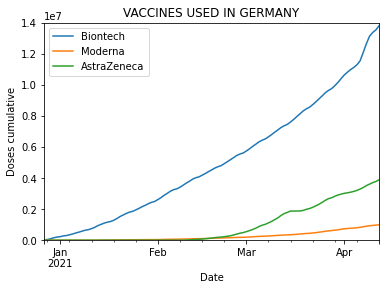

In [27]:
vaccine_use.plot(
    ylim=(0,max_doses),
    xlabel='Date',
    ylabel='Doses cumulative',
    title='VACCINES USED IN GERMANY')